In [22]:
# silence deprecation warnings from pulse
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

    

In [23]:
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp

In [24]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver

v = 5.
r = 0.02

static_hamiltonian = 2 * np.pi * v * Operator.from_label('Z') / 2
drive_term = 2 * np.pi * r * Operator.from_label('X') / 2

ham_solver = Solver(
    hamiltonian_operators=[drive_term],
    static_hamiltonian=static_hamiltonian,
    rotating_frame=static_hamiltonian,
)

In [25]:
from qiskit_dynamics import DiscreteSignal
from qiskit_dynamics.signals import Convolution

import jax.numpy as jnp

# define convolution filter
def gaus(t):
    sigma = 15
    _dt = 0.1
    return 2.*_dt/np.sqrt(2.*np.pi*sigma**2)*np.exp(-t**2/(2*sigma**2))

convolution = Convolution(gaus)

# define function mapping parameters to signals
def signal_mapping(params):

    # map samples into [-1, 1]
    bounded_samples = jnp.arctan(params) / (np.pi / 2)

    # pad with 0 at beginning
    padded_samples = jnp.append(jnp.array([0], dtype=complex), bounded_samples)

    # apply filter
    output_signal = convolution(DiscreteSignal(dt=1., samples=padded_samples))

    # set carrier frequency to v
    output_signal.carrier_freq = v

    return output_signal


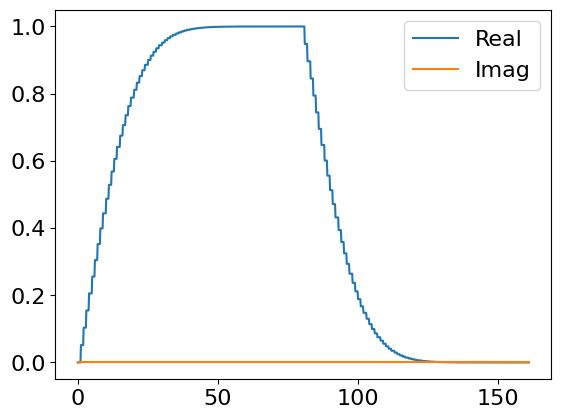

In [26]:
signal = signal_mapping(np.ones(80) * 1e8)
signal.draw(t0=0., tf=signal.duration * signal.dt, n=1000, function='envelope')

In [27]:
X_op = Operator.from_label('X').data

def fidelity(U):
    return jnp.abs(jnp.sum(X_op * U))**2 / 4.


In [28]:
def objective(params):

    # apply signal mapping and set signals
    signal = signal_mapping(params)

    # Simulate
    results = ham_solver.solve(
        y0=np.eye(2, dtype=complex),
        t_span=[0, signal.duration * signal.dt],
        signals=[signal],
        method='jax_odeint',
        atol=1e-8,
        rtol=1e-8
    )
    U = results.y[-1]

    # compute and return infidelity
    fid = fidelity(U)
    return 1. - fid

In [29]:
from jax import jit, value_and_grad
from scipy.optimize import minimize

jit_grad_obj = jit(value_and_grad(objective))

initial_guess = np.random.rand(80) - 0.5

opt_results = minimize(fun=jit_grad_obj, x0=initial_guess, jac=True, method='BFGS')
print(opt_results.message)
print('Number of function evaluations: ' + str(opt_results.nfev))
print('Function value: ' + str(opt_results.fun))

TypeError: asarray() got an unexpected keyword argument 'copy'

In [30]:
opt_signal = signal_mapping(opt_results.x)

opt_signal.draw(
    t0=0,
    tf=opt_signal.duration * opt_signal.dt,
    n=1000,
    function='envelope',
    title='Optimized envelope'
)


NameError: name 'opt_results' is not defined

In [31]:
opt_signal.samples.sum()

NameError: name 'opt_signal' is not defined

In [32]:
import sympy as sym
from qiskit import pulse

def lifted_gaussian(
    t: sym.Symbol,
    center,
    t_zero,
    sigma,
) -> sym.Expr:
    t_shifted = (t - center).expand()
    t_offset = (t_zero - center).expand()

    gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
    offset = sym.exp(-((t_offset / sigma) ** 2) / 2)

    return (gauss - offset) / (1 - offset)

def gaussian_square_generated_by_pulse(params):

    sigma, width = params
    _t, _duration, _amp, _sigma, _width, _angle = sym.symbols(
        "t, duration, amp, sigma, width, angle"
    )
    _center = _duration / 2

    _sq_t0 = _center - _width / 2
    _sq_t1 = _center + _width / 2

    _gaussian_ledge = lifted_gaussian(_t, _sq_t0, -1, _sigma)
    _gaussian_redge = lifted_gaussian(_t, _sq_t1, _duration + 1, _sigma)

    envelope_expr = (
        _amp
        * sym.exp(sym.I * _angle)
        * sym.Piecewise(
            (_gaussian_ledge, _t <= _sq_t0), (_gaussian_redge, _t >= _sq_t1), (1, True)
        )
    )

    # we need to set disable_validation True to enable jax-jitting.
    pulse.ScalableSymbolicPulse.disable_validation = True

    return pulse.ScalableSymbolicPulse(
            pulse_type="GaussianSquare",
            duration=230,
            amp=1,
            angle=0,
            parameters={"sigma": sigma, "width": width},
            envelope=envelope_expr,
            constraints=sym.And(_sigma > 0, _width >= 0, _duration >= _width),
            valid_amp_conditions=sym.Abs(_amp) <= 1.0,
        )


In [33]:
from qiskit_dynamics.pulse import InstructionToSignals

dt = 0.222
w = 5.

def objective(params):

    instance = gaussian_square_generated_by_pulse(params)

    with pulse.build() as Xp:
        pulse.play(instance, pulse.DriveChannel(0))

    converter = InstructionToSignals(dt, carriers={"d0": w})
    signal = converter.get_signals(Xp)

    result = ham_solver.solve(
        y0=np.eye(2, dtype=complex),
        t_span=[0, instance.duration * dt],
        signals=[signal],
        method='jax_odeint',
        atol=1e-8,
        rtol=1e-8
    )
    return 1. - fidelity(result[0].y[-1])


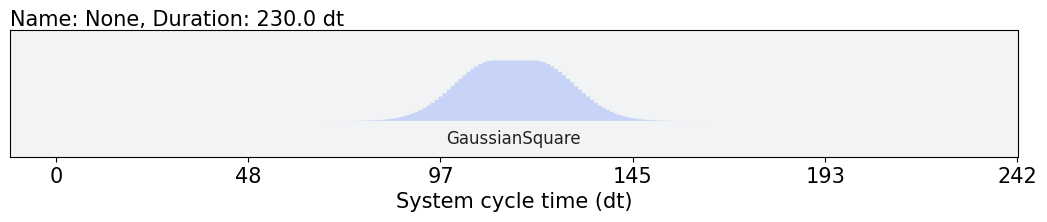

In [34]:
initial_params = np.array([10, 10])
gaussian_square_generated_by_pulse(initial_params).draw()

In [35]:
from jax import jit, value_and_grad
from scipy.optimize import minimize

jit_grad_obj = jit(value_and_grad(objective))

initial_params = np.array([10,10])


opt_results = minimize(fun=jit_grad_obj, x0=initial_params, jac=True, method='BFGS')

print(opt_results.message)
print(f"Optimized Sigma is {opt_results.x[0]} and Width is {opt_results.x[1]}")
print('Number of function evaluations: ' + str(opt_results.nfev))
print('Function value: ' + str(opt_results.fun))

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float64[]
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [36]:

gaussian_square_generated_by_pulse(opt_results.x).draw()

NameError: name 'opt_results' is not defined